<a href="https://colab.research.google.com/github/TheScottBailey/Line-Score-Analysis/blob/main/MLB_Line_Score_Analysis_2010_to_Present.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseball Line Score Analysis

For baseball, a line score shows the total runs by inning. Below is an example
of a typical line score. In addition to run totals by inning, this line score
also includes a run total, hit total, and error total for each team for the entire game.

![picture](https://www.sportspectator.com/fancentral/baseball/stats/boxscoreimages/line.jpg)

A value of X in a line score indicates that that inning was not played. In the example above, the bottom of the 9th inning was not played since St. Louis was winning at the inning half.

I obtained MLB line score data for 2010 to 2022 from:
https://sportsbookreviewsonline.com/scoresoddsarchives/mlb/mlboddsarchives.htm

Each season's data is contained in its own Excel file.

Let's find out what we can learn about how runs are distributed!

## Load and Clean Data

### Compile all datasets into one

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Set important variables
test_team = 'MIN'

In [12]:
# Read files into dictionary of dataframes
data_dict = {}
url = 'https://sportsbookreviewsonline.com/scoresoddsarchives/mlb/'
for i in range(2010,2023):
    # Read in the file to a dataframe
    filename = f'mlb%20odds%20{i}.xlsx'
    df_temp = pd.read_excel(url + filename)

    # Drop unnecessary columns
    drop_cols = df_temp.columns[15:]
    df_temp.drop(columns=drop_cols, inplace=True)
    df_temp.drop(columns=['Pitcher'], inplace=True)

    # Add a season column
    df_temp['GameYear'] = i

    # Append dataframe to a dictionary
    data_dict[f'df{i}'] = df_temp

In [59]:
# Concatenate the dictionary of dataframes into a single dataframe
df = pd.concat(data_dict.values(), ignore_index=True)
df.head()

,Date,Rot,VH,Team,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,Final,GameYear
0,404,931,V,NYY,0.0,2.0,0.0,3.0,0,0,2,0,0,7,2010
1,404,932,H,BOS,0.0,1.0,0.0,0.0,1,3,3,1,x,9,2010
2,405,901,V,PHI,0.0,0.0,0.0,5.0,0,2,4,0,0,11,2010
3,405,902,H,WAS,1.0,0.0,0.0,0.0,0,0,0,0,0,1,2010
4,405,903,V,MIA,0.0,0.0,0.0,0.0,0,1,0,0,0,1,2010


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57916 entries, 0 to 57915
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      57916 non-null  int64  
 1   Rot       57916 non-null  int64  
 2   VH        57916 non-null  object 
 3   Team      57916 non-null  object 
 4   1st       57914 non-null  float64
 5   2nd       57914 non-null  float64
 6   3rd       57914 non-null  float64
 7   4th       57914 non-null  float64
 8   5th       57914 non-null  object 
 9   6th       57912 non-null  object 
 10  7th       57909 non-null  object 
 11  8th       57902 non-null  object 
 12  9th       57893 non-null  object 
 13  Final     57916 non-null  object 
 14  GameYear  57916 non-null  int64  
dtypes: float64(4), int64(3), object(8)
memory usage: 6.6+ MB


### Check for null values

In [61]:
df.isnull().sum()

Date         0
Rot          0
VH           0
Team         0
1st          2
2nd          2
3rd          2
4th          2
5th          2
6th          4
7th          7
8th         14
9th         23
Final        0
GameYear     0
dtype: int64

### Treat null values

In [62]:
# 2 rows had nulls for all innings
# Both rows appear to pertain to the same game
# Dropped these rows as this does not appear to be a valid game
df = df[~df['1st'].isna()].copy()

# Remaining rows have complete run counts for the first 5 innings
# After the 5th inning, some rows have NaN values
# Replace NaN values with 0
inning_cols = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th']
df[inning_cols] = df[inning_cols].fillna(0)

# Check nulls again
df.isnull().sum()

Date        0
Rot         0
VH          0
Team        0
1st         0
2nd         0
3rd         0
4th         0
5th         0
6th         0
7th         0
8th         0
9th         0
Final       0
GameYear    0
dtype: int64

### Convert Data Types

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57914 entries, 0 to 57915
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      57914 non-null  int64  
 1   Rot       57914 non-null  int64  
 2   VH        57914 non-null  object 
 3   Team      57914 non-null  object 
 4   1st       57914 non-null  float64
 5   2nd       57914 non-null  float64
 6   3rd       57914 non-null  float64
 7   4th       57914 non-null  float64
 8   5th       57914 non-null  object 
 9   6th       57914 non-null  object 
 10  7th       57914 non-null  object 
 11  8th       57914 non-null  object 
 12  9th       57914 non-null  object 
 13  Final     57914 non-null  object 
 14  GameYear  57914 non-null  int64  
dtypes: float64(4), int64(3), object(8)
memory usage: 7.1+ MB


In [65]:
# Some of the inning columns are object type.
# This means at least some of the data in these columns is not numerical
# The non-numerical data in these columns are 'x' and '-' values to indicate
# that the inning was not played.
# Replace 'x' and '-' values with 0 in the inning columns
object_inning_columns = df.columns[8:15]
for col in object_inning_columns:
    df[col] = df[col].replace('x',0)
    df[col] = df[col].replace('-',0)

# Convert inning columns from object and float64 to int64
cols_to_convert = inning_cols.copy()
cols_to_convert.append('Final')
df[cols_to_convert] = df[cols_to_convert].astype('int64')

# Convert Date column from int64 to string to make it easier to parse
df['Date'] = df['Date'].astype('str')

# # Convert VH column to categorical as it only has 3 unique values
# df['VH'] = df['VH'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57914 entries, 0 to 57915
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      57914 non-null  object
 1   Rot       57914 non-null  int64 
 2   VH        57914 non-null  object
 3   Team      57914 non-null  object
 4   1st       57914 non-null  int64 
 5   2nd       57914 non-null  int64 
 6   3rd       57914 non-null  int64 
 7   4th       57914 non-null  int64 
 8   5th       57914 non-null  int64 
 9   6th       57914 non-null  int64 
 10  7th       57914 non-null  int64 
 11  8th       57914 non-null  int64 
 12  9th       57914 non-null  int64 
 13  Final     57914 non-null  int64 
 14  GameYear  57914 non-null  int64 
dtypes: int64(12), object(3)
memory usage: 7.1+ MB


### Check for Other Invalid Values

In [66]:
print(cols_to_convert)
cols_to_keep = cols_to_convert.copy()
cols_to_keep.append('Team')
cols_to_keep.remove('Final')
print(cols_to_keep)

['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', 'Final']
['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', 'Team']


In [67]:
# Inspect unique values for the inning columns
for col in df.columns[4:14]:
    print(df[col].unique())

[ 0  1  2  3  6  4  5 10  7  9  8 12 11]
[ 2  1  0  3  4  7  5  6  9  8 10 11 -1]
[ 0  1  2  6  3  5  4  7  8 11  9 10 12]
[ 3  0  5  2  1  4 13 10  6  8  9  7]
[ 0  1  5  2  3  4  6  7  8 11  9 10 13 -1]
[ 0  3  2  1  4  6  7  5  9 10  8]
[ 2  3  4  0  1  6  5  7  9  8 10 12 11]
[ 0  1  3  2  4  5  6  7  9  8 12 10 -1 11 -2]
[ 0  5  2  1  4  3  6  8  7  9 10]
[ 7  9 11  1  6  5  3 16  2  0  4  8 10 15 17 14 12 20 13 18 19 22 21 23
 25 24 29]


### Treat Invalid Values

In [68]:
# From above, some of the columns have negative run counts
# Upon further investigation of those games, these run counts
# should be converted to 0

for col in cols_to_convert:
    df.loc[df[col] < 0] = 0

# Inspect unique values for the inning columns
# All values should be 0 or greater
for col in cols_to_convert:
    print(df[col].unique())

[ 0  1  2  3  6  4  5 10  7  9  8 12 11]
[ 2  1  0  3  4  7  5  6  9  8 10 11]
[ 0  1  2  6  3  5  4  7  8 11  9 10 12]
[ 3  0  5  2  1  4 13 10  6  8  9  7]
[ 0  1  5  2  3  4  6  7  8 11  9 10 13]
[ 0  3  2  1  4  6  7  5  9 10  8]
[ 2  3  4  0  1  6  5  7  9  8 10 12 11]
[ 0  1  3  2  4  5  6  7  9  8 12 10 11]
[ 0  5  2  1  4  3  6  8  7  9 10]
[ 7  9 11  1  6  5  3 16  2  0  4  8 10 15 17 14 12 20 13 18 19 22 21 23
 25 24 29]


In [69]:
cols_to_keep

['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', 'Team']

In [70]:
# Check unique team names
unique_teams = df['Team'].unique()
print(unique_teams)
print(f'There are {len(unique_teams)} unique teams.')

['NYY' 'BOS' 'PHI' 'WAS' 'MIA' 'NYM' 'STL' 'CIN' 'LOS' 'PIT' 'COL' 'MIL'
 'CUB' 'ATL' 'SDG' 'ARI' 'SFO' 'HOU' 'CLE' 'CWS' 'TOR' 'TEX' 'DET' 'KAN'
 'MIN' 'LAA' 'SEA' 'OAK' 'BAL' 'TAM' 'LAD' 0 'SFG' 'BRS' 'CHC']
There are 35 unique teams.


In [71]:
# Drop rows where Team is 0
# There were no data in these rows
df = df[df['Team'] != 0]

In [72]:
# The above team count was 35 teams. That number is now 34 teams since we have
# dropped teams labeled as 0. However, there are only 30 teams in the MLB. Upon
# further investigation, some teams appeared to be mislabeled, which could
# result in a distortion in the analysis. 

# The mislabeled teams are: BRS, CHC, SFO, and LOS. 
# These teams should be relabeled as BOS, CUB, SFG, and LAD, respectively.
df.loc[df['Team'] == 'BRS', 'Team'] = 'BOS'
df.loc[df['Team'] == 'CHC', 'Team'] = 'CUB'
df.loc[df['Team'] == 'SFO', 'Team'] = 'SFG'
df.loc[df['Team'] == 'LOS', 'Team'] = 'LAD'

### Check that inning runs add up to the Final run count

In [73]:
# Create TotalRuns column as the sum of each of the innings
df['TotalRuns'] = df['1st'] + df['2nd'] + df['3rd'] + df['4th'] + df['5th'] + df['6th'] + df['7th'] + df['8th'] + df['9th']

# Display any rows where the Final score does not match the Total runs
df[df['Final'] - df['TotalRuns'] != 0]

,Date,Rot,VH,Team,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,Final,GameYear,TotalRuns
41,406,964,H,OAK,0,0,0,1,0,0,0,0,0,2,2010,1
47,407,906,H,PIT,3,0,0,0,0,0,0,0,0,4,2010,3
54,407,913,V,MIA,1,0,2,0,1,1,1,0,0,7,2010,6
58,407,917,V,NYY,0,0,0,0,0,0,1,0,0,3,2010,1
66,407,925,V,DET,0,0,0,0,0,0,0,0,1,2,2010,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57863,611,910,H,SDG,0,0,1,0,0,0,0,0,0,2,2022,1
57868,611,915,V,TEX,0,0,0,0,4,1,2,0,0,11,2022,7
57869,611,916,H,CWS,0,2,0,3,2,0,0,0,0,9,2022,7
57902,612,967,V,TEX,0,0,2,1,0,0,0,0,0,8,2022,3


### Treat run discrepancies

There were 2980 rows where the total of each inning's runs did not match the final score for the game. Upon further investigation, it appears that these discrepancies are due to runs scored during extra innings. Since the line score data do not extend past the 9th inning, I am not able to allocate the excess runs to specific innings. Instead, I will create a new column, EIRuns, to account for these.

In [74]:
# Create new column
df['EIRuns'] = df['Final'] - df['TotalRuns']

# # Drop TotalRuns column as it is no longer needed
# df.drop(columns=['TotalRuns'])

# Rearrange columns
df = df[['Date', 'Rot', 'VH', 'Team', '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', 'EIRuns', 'Final', 'GameYear']]

# Add EIRuns to inning_cols list
inning_cols.append('EIRuns')

# Show rows with nonzero EIRuns
df[df['EIRuns'] != 0]

,Date,Rot,VH,Team,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,EIRuns,Final,GameYear
41,406,964,H,OAK,0,0,0,1,0,0,0,0,0,1,2,2010
47,407,906,H,PIT,3,0,0,0,0,0,0,0,0,1,4,2010
54,407,913,V,MIA,1,0,2,0,1,1,1,0,0,1,7,2010
58,407,917,V,NYY,0,0,0,0,0,0,1,0,0,2,3,2010
66,407,925,V,DET,0,0,0,0,0,0,0,0,1,1,2,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57863,611,910,H,SDG,0,0,1,0,0,0,0,0,0,1,2,2022
57868,611,915,V,TEX,0,0,0,0,4,1,2,0,0,4,11,2022
57869,611,916,H,CWS,0,2,0,3,2,0,0,0,0,2,9,2022
57902,612,967,V,TEX,0,0,2,1,0,0,0,0,0,5,8,2022


### Extract Date Data

The Date column contains a 3-4 digit number. This number is in m/dd format. I will extract the month and date values to new columns.

In [77]:
# Add GameMonth column
# If Date is 3 characters long, then month is 1st character only
# If Date is 4 characters long, then month is first 2 characters
def month(row):
    if len(row['Date']) == 3:
        return row['Date'][0]
    elif len(row['Date']) == 4:
        return row['Date'][:1]
df['GameMonth'] = df.apply(lambda row: month(row), axis=1)
df['GameMonth'] = df['GameMonth'].astype('int64')

# Add GameDate column
df['GameDate'] = df['Date'].str[-2:]
df['GameDate'] = df['GameDate'].astype('int64')

df.head()

,Date,Rot,VH,Team,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,EIRuns,Final,GameYear,GameMonth,GameDate
0,404,931,V,NYY,0,2,0,3,0,0,2,0,0,0,7,2010,4,4
1,404,932,H,BOS,0,1,0,0,1,3,3,1,0,0,9,2010,4,4
2,405,901,V,PHI,0,0,0,5,0,2,4,0,0,0,11,2010,4,5
3,405,902,H,WAS,1,0,0,0,0,0,0,0,0,0,1,2010,4,5
4,405,903,V,MIA,0,0,0,0,0,1,0,0,0,0,1,2010,4,5


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57910 entries, 0 to 57915
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       57910 non-null  object
 1   Rot        57910 non-null  int64 
 2   VH         57910 non-null  object
 3   Team       57910 non-null  object
 4   1st        57910 non-null  int64 
 5   2nd        57910 non-null  int64 
 6   3rd        57910 non-null  int64 
 7   4th        57910 non-null  int64 
 8   5th        57910 non-null  int64 
 9   6th        57910 non-null  int64 
 10  7th        57910 non-null  int64 
 11  8th        57910 non-null  int64 
 12  9th        57910 non-null  int64 
 13  EIRuns     57910 non-null  int64 
 14  Final      57910 non-null  int64 
 15  GameYear   57910 non-null  int64 
 16  GameMonth  57910 non-null  int64 
 17  GameDate   57910 non-null  int64 
dtypes: int64(15), object(3)
memory usage: 8.4+ MB


## Analyze the Data

### Questions:
* What teams have scored the most runs over the period?
* What does the distribution of scores by inning look like for the whole MLB?
* What does the distribution of scores by inning look like for each league?
* What does the distribution of scores by inning look like for the Minnesota Twins?
* What are the total runs by month for the whole MLB?
* What are hte total runs by month for the Minnesota Twins?

### What teams have scored the most runs over the period?

In [81]:
df_by_team = df.groupby(df['Team']).sum().reset_index().sort_values(by='Final', ascending=False)
df_by_team = df_by_team.drop(columns=['GameYear', 'GameMonth', 'GameDate'])
df_by_team.head()

,Team,Rot,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,EIRuns,Final
3,BOS,1840527,1134,1103,1205,1079,1173,1103,1080,1004,645,215,9741
18,NYY,1848262,1151,1015,1131,1097,1064,1077,1125,979,684,158,9481
13,LAD,1870195,1112,870,1052,1042,1068,1092,1034,956,652,185,9063
6,COL,1786436,1190,864,1015,1161,1070,1030,1034,932,621,128,9045
27,TEX,1839898,1046,948,1080,1135,1067,1060,938,889,651,157,8971


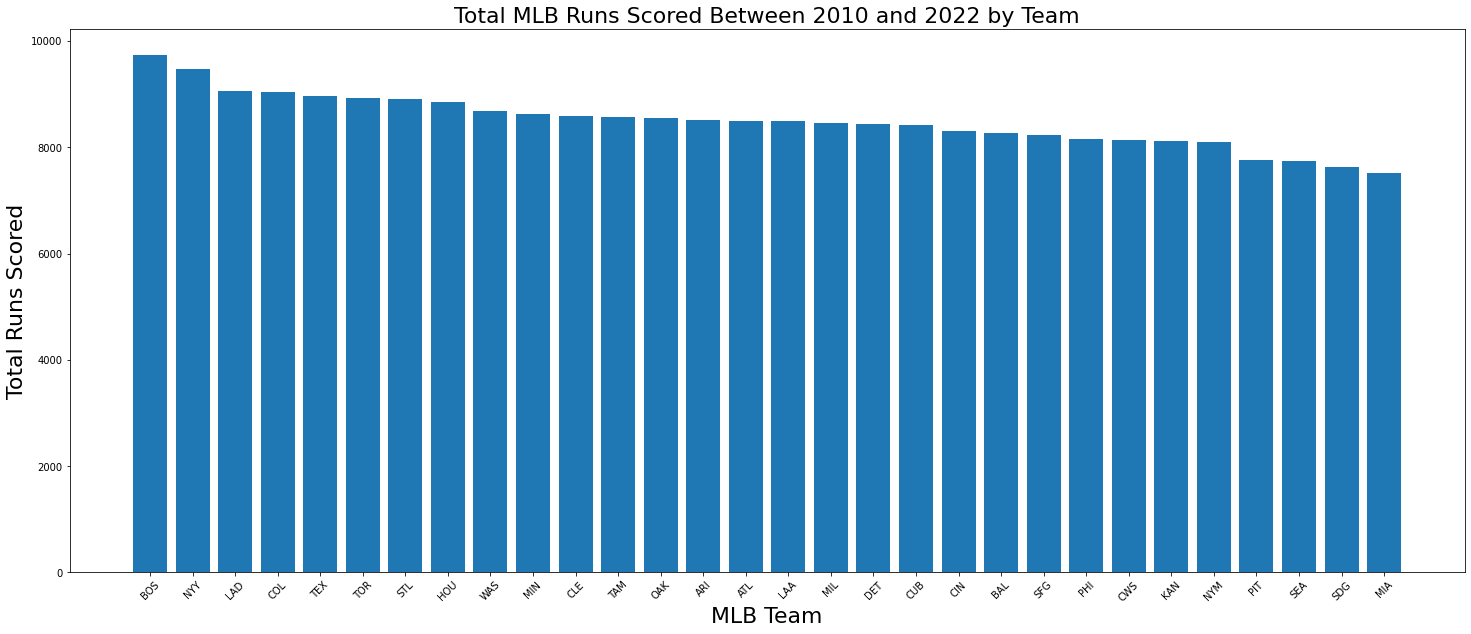

In [83]:
fontsize = 22
plt.figure(figsize=(25, 10))
plt.bar(df_by_team['Team'], df_by_team['Final'])
#rcParams.update({'font.size': 32})
plt.xticks(rotation = 45)
plt.title('Total MLB Runs Scored Between 2010 and 2022 by Team', fontsize=fontsize)
plt.xlabel('MLB Team', fontsize=fontsize)
plt.ylabel('Total Runs Scored', fontsize=fontsize)
plt.show()

There are two clear standouts for total runs scored between 2010 and 2022. The Boston Red Sox have scored the most runs, followed by the New York Yankees.

### What does the distribution of scores by inning look like for the whole MLB?

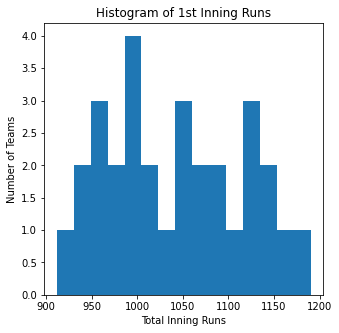

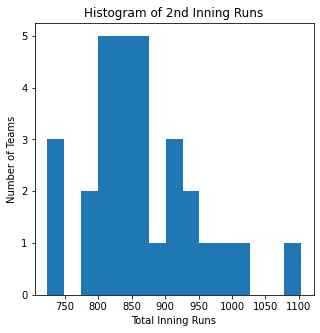

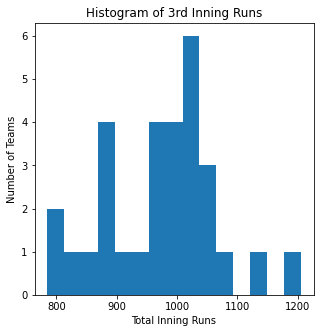

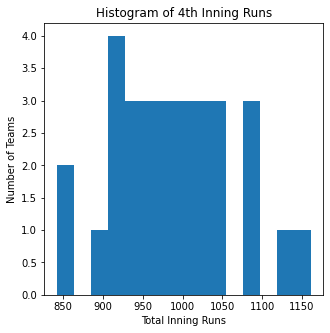

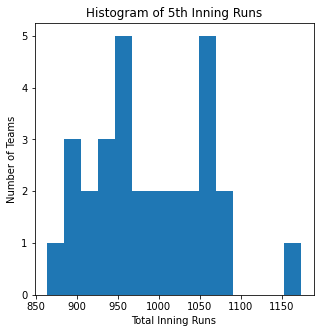

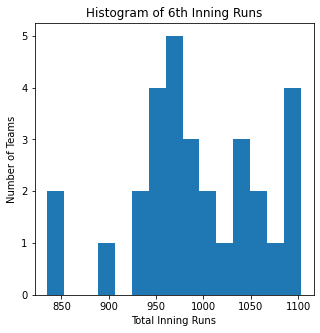

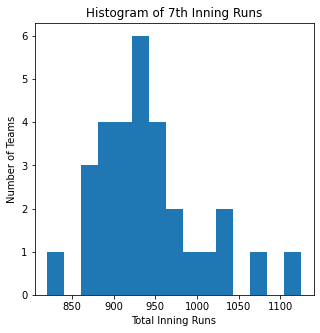

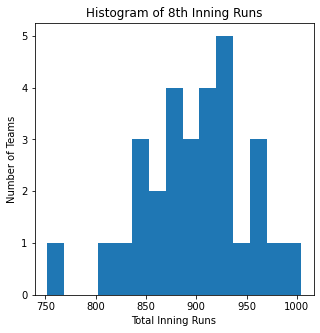

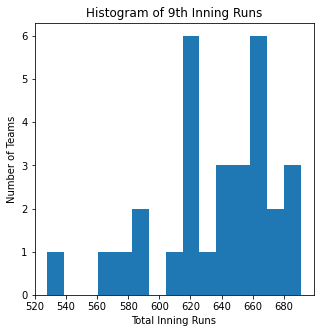

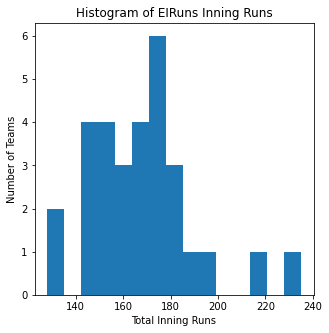

In [97]:
for inning in inning_cols:
    plt.figure(figsize=(5,5))
    plt.hist(df_by_team[inning], bins=15)
    plt.title(f'Histogram of {inning} Inning Runs')
    plt.xlabel('Total Inning Runs')
    plt.ylabel('Number of Teams')
    plt.show()
# plt.hist(df_by_team['1st'], bins=15)
# plt.show()

### What were the runs scored as a percentage of the total runs scored
### for each inning for all MLB teams during the period?

In [98]:
runs_by_inning = df_by_team[inning_cols].sum().reset_index()
runs_by_inning.rename(columns={'index': 'Inning', 0: 'Runs'}, inplace=True)
runs_by_inning['pct_of_total'] = runs_by_inning['Runs'] / runs_by_inning['Runs'].sum()
runs_by_inning

,Inning,Runs,pct_of_total
0,1st,31267,0.122724
1,2nd,25926,0.101760
2,3rd,29108,0.114250
3,4th,29660,0.116416
4,5th,29678,0.116487
5,6th,29850,0.117162
6,7th,28250,0.110882
7,8th,26897,0.105572
8,9th,19102,0.074976
9,EIRuns,5037,0.019770


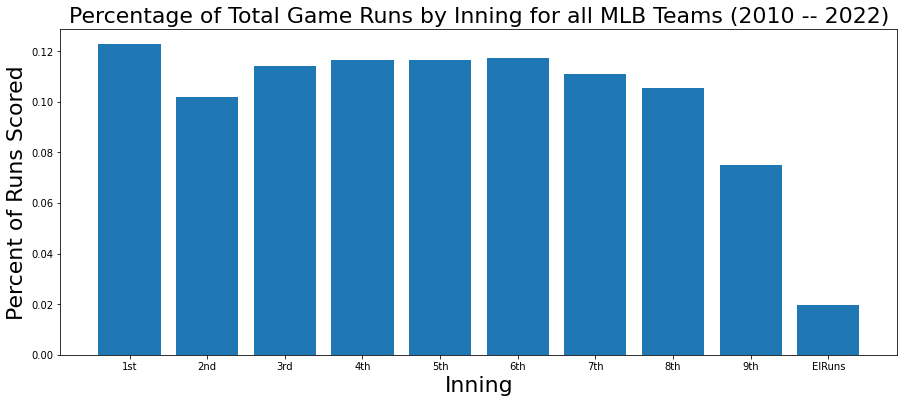

In [99]:
fontsize = 22
plt.figure(figsize=(15, 6))
plt.bar(runs_by_inning['Inning'], runs_by_inning['pct_of_total'])
plt.title('Percentage of Total Game Runs by Inning for all MLB Teams (2010 -- 2022)', fontsize=fontsize)
plt.xlabel('Inning', fontsize=fontsize)
plt.ylabel('Percent of Runs Scored', fontsize=fontsize)
plt.show()

### What does the distribution of scores by inning look like for the Minnesota Twins?

In [100]:
runs_by_team = df[df['Team'] == test_team]

keep = cols_to_convert.copy()
keep.append('Team')
keep.remove('Final')
runs_by_team = runs_by_team[keep]

runs_by_team = df.groupby(df['Team']).sum().reset_index().sort_values(by='Final', ascending=False)

runs_by_team = runs_by_team[runs_by_team['Team'] == test_team]

runs_by_team = runs_by_team[inning_cols].sum().reset_index()
runs_by_team.rename(columns={'index': 'Inning', 0: 'Runs'}, inplace=True)
runs_by_team['pct_of_total'] = runs_by_team['Runs'] / runs_by_team['Runs'].sum()

runs_by_team

,Inning,Runs,pct_of_total
0,1st,1089,0.126129
1,2nd,952,0.110262
2,3rd,1026,0.118833
3,4th,1000,0.115821
4,5th,1044,0.120917
5,6th,966,0.111883
6,7th,913,0.105745
7,8th,906,0.104934
8,9th,588,0.068103
9,EIRuns,150,0.017373


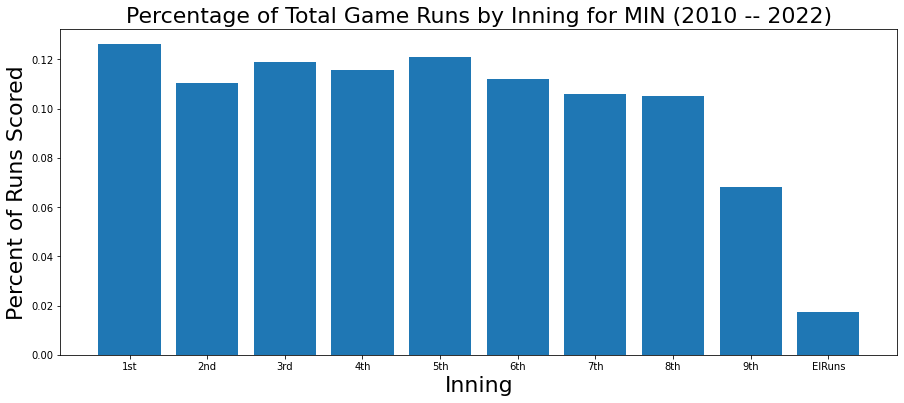

In [101]:
fontsize = 22
plt.figure(figsize=(15, 6))
plt.bar(runs_by_team['Inning'], runs_by_team['pct_of_total'])
plt.title(f'Percentage of Total Game Runs by Inning for {test_team} (2010 -- 2022)', fontsize=fontsize)
plt.xlabel('Inning', fontsize=fontsize)
plt.ylabel('Percent of Runs Scored', fontsize=fontsize)
plt.show()